# Evaluation of Agents

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import gen_states, evaluate_agent, evaluate_agent_advanced
from Baseline_agent.baseline_agent import BaselineAgent
from linearAQ_agent.linearAQ import LinearAQ
from NNQ_agent.NNQ import NNQ
from Q_agent.mdp import MDP, TabularQ, Q_learn, epsilon_greedy

In [2]:
# Parameter Initializations 
path = 'histories/Apple_cleaned.csv'
window_size = 5  # time window size
history_size = 3  # number of previous days to consider
train, val, test = gen_states(path, window_size, history_size)  # data
actions = ['buy', 'wait']  # action space
epsilon = .05  # amount of randomness
discount = 1  # discount factor
alpha = .1
num_layers = 15  # number of layers in neural net
num_units = 9  # number of nodes per layer in neural net
c = -1 # constant for baseline model

In [3]:
# Q agent initialization
def gen_Qhist(path):
    # imports history from csv
    df = pd.read_csv(path)
    hist = df.Close - df.Open
    hist = hist.apply(np.sign)
    hist[hist == -1] = 0  # no price change is considered a decrease
    hist = [int(h) for h in hist]
    return hist

def gen_Qstates(h):
    # generates possible states for a history window h
    states = [('T')]
    for i in range(2**(h+1)):
        b = bin(i)[2:]
        l = len(b)
        b = str(0) * ((h+1) - l) + b
        states.append(tuple([int(i) for i in b]))

    return states

hist = gen_Qhist(path)
p = np.copy(history_size)  # pointer index to history (start at 4th element so we have a history window
states = gen_Qstates(history_size)
actions = ['buy', 'wait']
start = tuple([hist[i] for i in range(history_size)])
reward = 1  
wait_penalty = -.1  

# transition_model: function from (state, action) to return the next state at point "p+1" in the history
def transition_model(state, action, p):
    if p == len(hist):
        return None
    elif action == 'buy':
        return ('T')  # signifying terminal state has been reached
    else:
        new_state = list(state[1:])
        new_state.append(hist[p])
        return tuple(new_state)

# reward_fn: function from (state, action) to real-valued reward at point "p" in the history
def reward_fn(state, action, p):
    if p == len(hist):  # if we have reached the end of the data
        return None
    elif state == ('T'):  # if terminal state
        return 0
    elif action == 'buy' and hist[p] == 1:  # if stock went up after buying
        return reward
    elif action == 'buy' and hist[p] == 0:  # if stock went down after buying
        return -reward
    else:
        return wait_penalty
    
# Function to Transfer Q agent to time window framework

def gen_Qepisodes(path, window_size, history_size):
    # read in data
    df = gen_Qhist(path)

    df_split = np.array([df[i-history_size:i+window_size] for i in range(
        history_size, len(df) - window_size - 1, window_size)][:-1])

    result_states = []
    for episode in df_split:
        episode_states = []
        for t in range(window_size):
            episode_states.append(tuple(episode[t:t+history_size+1].reshape(-1)))
        result_states.append(episode_states)

    # split into train/val/test (80%, 10%, 10%)
    train = result_states[:int(.8 * len(result_states))]
    val = result_states[int(.8* len(result_states)):int(.9 * len(result_states))]
    test = result_states[int(.9 * len(result_states)):]

    return train, val, test


stock_agent = MDP(states, actions, transition_model, reward_fn, p, hist, history_size, discount)
Q = TabularQ(stock_agent.states, stock_agent.actions)
Q, _ = Q_learn(stock_agent, Q, iters=2*len(hist[p:-1])+1, eps = epsilon) 
train_Q, val_Q, test_Q = gen_Qepisodes(path, window_size, history_size)

In [4]:
# Helper functions to evaluate Q agent in time window framework

def evaluate_Qagent(agent, states_data, states_new, window_size, verbose=True):
    """
    This evaluation is based on how much the close price is lower when the
    agent decides to buy compared to the initial price of the time window.
    """
    scores = []
    never_bought_count = 0
    time_bought = np.zeros(window_size + 1)
    for episode, episode_new in zip(states_data, states_new):
        for t, (state, state_new) in enumerate(zip(episode, episode_new)):
            if t == len(episode) - 1:
                # You have to buy at last time frame if didn't buy before
                action = "buy"
                never_bought_count += 1
                time_bought[window_size] += 1
                scores.append(-state_new[-2])

                break
            else:
                # Get the best action for this state
                action = epsilon_greedy(agent, state, eps=0)
                if action == "buy":
                    scores.append(-state_new[-2])
                    time_bought[t] += 1
                    break
    score = np.mean(scores)
    proportion_no_action = never_bought_count / len(states_data) * 100

    if verbose:
        print("Average score for the agent is {} and doesn't buy in {}% of the cases.".format(
            score, proportion_no_action))
        for t, c in enumerate(time_bought):
            if t < window_size:
                print("t=%i  Bought %i times." % (t, c))
            else:
                print("Did not buy %i times." % c)

    return score, proportion_no_action, time_bought

def evaluate_Qagent_function(agent, states_data, verbose):
    return evaluate_Qagent(agent, states_data, test, window_size, verbose=verbose)

def reset_Qagent(agent):
    hist = gen_Qhist(path)
    p = np.copy(history_size)
    states = gen_Qstates(history_size)
    actions = ['buy', 'wait']

    stock_agent = MDP(states, actions, transition_model, reward_fn, p,
                      hist, history_size, discount)
    agent = TabularQ(stock_agent.states, stock_agent.actions)
    agent, _ = Q_learn(stock_agent, agent, iters=2 * len(hist[p:-1]) + 1,
                       eps=epsilon)  # setting eps = 0 means no epsilon-greedy
    return agent

In [8]:
# Agent Evaluation (Takes a while)
base_agent = BaselineAgent(c)
print("Loading linear agent...")
linear_agent = LinearAQ('train', actions, train, epsilon, discount, alpha)
print("Loading NNQ agent...")
nn_agent = NNQ('train', actions, train, epsilon, discount, num_layers, num_units)
n = 5

print('Evaluating Baseline Agent...')
base_profit, base_noaction, base_timebought = evaluate_agent(base_agent, val, verbose=False)

print('Evaluating Q-learning Agent...')
q_profits = evaluate_agent_advanced(Q, test_Q, n=n, evaluate_agent_function=evaluate_Qagent_function, 
                                    reset_agent_function=reset_Qagent, verbose=False)

print('Evaluating Linear Agent...')
linear_profits = evaluate_agent_advanced(linear_agent, test, n=n, verbose=False)

print('Evaluating NN Agent...')
nn_profits = evaluate_agent_advanced(nn_agent, test, n=n, verbose=True)

Loading linear agent...
Loading NNQ agent...
Evaluating Baseline Agent...
Evaluating Q-learning Agent...
Evaluating Linear Agent...
Evaluating NN Agent...
1/5
2/5
3/5


KeyboardInterrupt: 

NameError: name 'linear_profits' is not defined

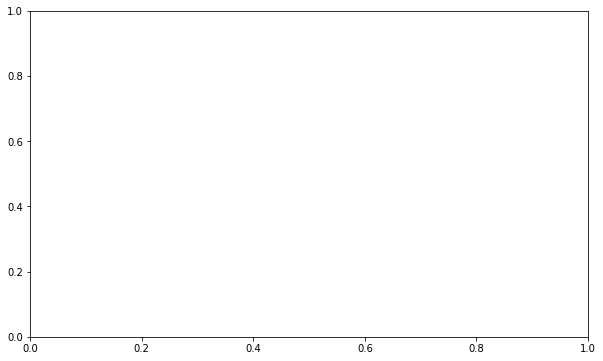

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(linear_profits, color='b', alpha=.3, label='Linear Agent')
ax.hist(q_profits, color='g', alpha=.3, label='Q Agent')
ax.hist(nn_profits, color='r', alpha=.3, label='NN agent')
ax.axvline(x=base_profit, color='k', label = 'Baseline')
ax.set_xlabel('Net Profit ($)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title('Agent Performance Comparison', fontsize=20)
ax.legend(fontsize=10)
plt.savefig('images/agent_comparison.png')